In [28]:
#universal sentence encoder
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import spacy
from nltk.corpus import stopwords 
stops = set(stopwords.words('english'))
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint

from IPython.display import Image
import re

# Important
This is an LDA model, therefore we can ignore elements of semantics, syntax, etc. We are utilizing Bag of Words methodologies, and therefore do not need to relate features in terms of contextual information, i.e, each document is a bag of words that can be used to inform a distribution that will be sampled.

Sampling can be done via gibbs iterative sampling, or bayes.

In [29]:
#refer to json_to_csv.ipynb for creating the csv below
df = pd.read_csv('C:/Users/eovit/Python/Kaggle/research_papers_v1.1.csv')

In [30]:
#below is common preprocessing, motivated by the code at: https://www.kaggle.com/matteomuffo/a-fine-grained-covid-19-question-answering-engine
def preprocessing(text):
    # remove mail
    text = re.sub(r'[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,}', 'MAIL', text)
    # remove doi
    text = re.sub(r'https\:\/\/doi\.org[^\s]+', 'DOI', text)
    # remove https
    text = re.sub(r'(\()?\s?http(s)?\:\/\/[^\)]+(\))?', r'\g<1>LINK\g<3>', text)
    # remove single characters repeated at least 3 times for spacing error (e.g. s u m m a r y)
    text = re.sub(r'(\w\s+){3,}', ' ', text)
    # replace tags (e.g. [3] [4] [5]) with whitespace
    text = re.sub(r'(\[\d+\]\,?\s?){3,}(\.|\,)?', r' \g<2>', text)
    # replace tags (e.g. [3, 4, 5]) with whitespace
    text = re.sub(r'\[[\d\,\s]+\]', ' ',text)
     # replace tags (e.g. (NUM1) repeated at least 3 times with whitespace
    text = re.sub(r'(\(\d+\)\s){3,}', ' ',text)
    # remove all full stops as abbreviations (e.g. i.e. cit. and so on)
    text = re.sub(r'\.(\s)?([^A-Z\s])', r' \g<1>\g<2>', text)
    # return lowercase text
    return text.lower()

#secondary preprocessing incase we miss anything
#source https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html
def ppreprocess(data):
 
    temp = data.copy()
    temp = [re.sub(r"\'", "", x) for x in temp] #remove single quotes
    temp = [re.sub(r"\,", "", x) for x in temp] #remove commas, technically don't need to but I like too
    for sentence in temp:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [31]:
df.all_body = df.all_body.apply(preprocessing)


In [32]:
print(f'The size of our df is, {df.shape}')

The size of our df is, (2670, 5)


In [33]:
#lets make sure that things appear the way we want them to
df.head() 

,Unnamed: 0,title,authors,abstract,all_body
0,0,The RNA pseudoknots in foot-and-mouth disease ...,"[""Joseph ['C'] Ward"", 'Lidia Lasecka-Dykes', '...",word count: 194 22 Text word count: 5168 23 24...,"vp3, and vp0 (which is further processed to vp..."
1,1,Population modeling of early COVID-19 epidemic...,"['Mélanie Prague', 'Linda Wittkop', 'Quentin C...",We propose a population approach to model the ...,"in december 2019, grouped pneumonia cases have..."
2,2,Analysis Title: Regaining perspective on SARS-...,"['Carla Mavian', 'Simone Marini', 'Costanza Ma...","During the past three months, a new coronaviru...","in december 2019, a novel coronavirus, sars-co..."
3,3,Healthcare-resource-adjusted vulnerabilities t...,"['Hanchu Zhou', 'Jiannan Yang', 'Kaicheng Tang...",NaN,the 2019-ncov epidemic has spread across china...
4,4,Relationship between Average Daily Temperature...,"['Behzad Pirouz', 'Amirsina Golmohammadi', ""Ha...",The rapid outbreak of the new Coronavirus pand...,the outbreak of infectious diseases has always...


In [34]:
#create a collection of all the elements in the all_body column
data = df.all_body.values.tolist()

In [36]:
#apply secondary preprocessing (which yields a generator) and format it as a list into a manageable data structure 
#THIS IS A LIST OF LISTS REMEMBER THIS
corpus = list(ppreprocess(data)) 

In [41]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(corpus, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[corpus], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#interesting to note that we do not see any trigrams, indicating that we did not meet the threshold, which we could perhaps lower
print(trigram_mod[bigram_mod[corpus[0]]])

['vp', 'and', 'vp', 'which', 'is', 'further', 'processed', 'to', 'vp', 'and', 'vp', 'during', 'virus', 'assembly', 'the', 'and', 'regions', 'encode', 'the', 'non', 'structural', 'proteins', 'and', 'and', 'vpg', 'pro', 'and', 'structural', 'protein', 'coding', 'region', 'is', 'replaced', 'by', 'reporter', 'genes', 'allow', 'the', 'study', 'of', 'genome', 'replication', 'without', 'the', 'requirement', 'for', 'high', 'containment', 'figure', 'the', 'fmdv', 'utr', 'is', 'the', 'largest', 'known', 'picornavirus', 'utr', 'comprising', 'approximately', 'nucleotides', 'and', 'containing', 'several', 'highly', 'structured', 'regions', 'the', 'first', 'nucleotides', 'at', 'the', 'end', 'are', 'predicted', 'to', 'fold', 'into', 'single', 'large', 'stem_loop', 'termed', 'the', 'fragment', 'followed', 'by', 'the', 'pks', 'were', 'originally', 'predicted', 'in', 'and', 'consist', 'of', 'two', 'to', 'four', 'tandem', 'repeats', 'of', 'nucleotide', 'region', 'containing', 'small', 'stem_loop', 'and',

In [42]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    """
    Input: texts <collection of documents, aka corpus>
    ------------
    Output: return tokenized text that meets return criteria <gensim.utils.simple_preprocessing> and LEN(WORD) > 3
    """
    #remove words less than 3 can remove certain redundancies in the paper
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stops and len(word) > 3] for doc in texts]

def make_bigrams(texts):
    """
    Input: texts <collection of documents, aka corpus>
    ------------
    Output: tokenized bigram representation of each document
    """
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    """
    Input: texts <collection of documents, aka corpus>
    ------------
    Output: tokenized trigram representation of each document
    """
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Input: texts <collection of documents, aka corpus>
           list of POSTAGS check: https://spacy.io/api/annotation
    ------------
    Output: leammatized representation of corpus, with accompanying tagging from Spacy
    """
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [56]:
# Remove Stop Words
corpus_nostops = remove_stopwords(corpus)

# Form Bigrams
corpus_bigrams = make_bigrams(corpus_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
corpus_lemmatized = lemmatization(corpus_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(corpus_lemmatized[:1])

[['process', 'virus', 'assembly', 'region', 'encode', 'structural', 'protein', 'structural', 'protein', 'code', 'region', 'replace', 'reporter', 'gene', 'allow', 'genome', 'replication', 'requirement', 'high', 'containment', 'figure', 'fmdv', 'large', 'know', 'picornavirus', 'comprise', 'approximately', 'nucleotide', 'contain', 'several', 'highly', 'structured', 'region', 'first', 'nucleotide', 'predict', 'fold', 'single', 'large', 'term', 'fragment', 'follow', 'originally', 'predict', 'consist', 'repeat', 'region', 'contain', 'small', 'downstream', 'interaction', 'site', 'figure', 'sequence', 'similarity', 'figure', 'speculate', 'form', 'duplication', 'event', 'viral', 'replication', 'probably', 'involve', 'recombination', 'present', 'different', 'virus', 'isolate', 'strain', 'identify', 'less', 'emphasise', 'potential', 'importance', 'viral', 'report', 'picornavirus', 'author', 'funder', 'reuse_allowed', 'without_permission', 'occur', 'absence', 'least', 'require', 'replication', 'fu

In [48]:
#lets create the main inputs into the LDA model, which are the id2word(doc), which is dictionary of the word index adn frequency per document
#the other input to add is the corpus , which is the entire id2word(doc) collection, so it can be thought of as a nested dictionary 
# Create Dictionary
id2word = corpora.Dictionary(corpus_lemmatized)

# Create Corpus
texts = corpus_lemmatized

# Term Document Frequency
f_corpus = [id2word.doc2bow(text) for text in texts]

# View
print(f_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 3), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 10), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 1), (29, 3), (30, 1), (31, 4), (32, 3), (33, 1), (34, 3), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 3), (42, 1), (43, 1), (44, 9), (45, 1), (46, 2), (47, 1), (48, 2), (49, 11), (50, 2), (51, 3), (52, 1), (53, 1), (54, 2), (55, 1), (56, 2), (57, 1), (58, 3), (59, 2), (60, 1), (61, 6), (62, 3), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 4), (71, 1), (72, 1), (73, 4), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 5), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 5), (96, 2), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 1), (103, 8), (104, 1), (105, 1), (106, 5), (107, 1), (108, 1), (109, 1), (110, 

In [50]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in f_corpus[:1]]

[[('able', 1),
  ('absence', 1),
  ('achieve', 1),
  ('addition', 2),
  ('advantage', 3),
  ('adverse', 1),
  ('agree', 2),
  ('alighnment', 1),
  ('allow', 1),
  ('already', 1),
  ('also', 2),
  ('amount', 1),
  ('amplification', 1),
  ('analysis', 1),
  ('appear', 1),
  ('approximately', 1),
  ('aspect', 1),
  ('assay', 1),
  ('assemble', 2),
  ('assembly', 1),
  ('assess', 1),
  ('author', 10),
  ('basic', 1),
  ('blast', 1),
  ('calculated', 1),
  ('can', 1),
  ('cell', 3),
  ('change', 1),
  ('check', 1),
  ('clone', 3),
  ('code', 1),
  ('compare', 4),
  ('competent', 3),
  ('competition', 1),
  ('competitive', 3),
  ('complete', 1),
  ('comprise', 1),
  ('confer', 2),
  ('confirm', 1),
  ('conga', 1),
  ('consist', 1),
  ('consistent', 3),
  ('construct', 1),
  ('construction', 1),
  ('contain', 9),
  ('containment', 1),
  ('contig', 2),
  ('control', 1),
  ('copy', 2),
  ('copyright', 11),
  ('could', 2),
  ('create', 3),
  ('culture', 1),
  ('date', 1),
  ('datum', 2),
  ('dec

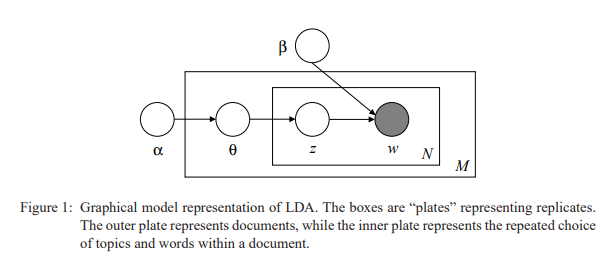

In [51]:
Image(filename = "C:/Users/eovit/Python/Kaggle/Lda.png")
#where corpus is collectino of M documents [D]
#Doc containts N words
#Z is topic selected
#solve p(wN | Zn , ThetaN)

In [53]:
# Build LDA model; can be fine tuned for coherence and perplexity, where K = num_topics, we are updating every iteration

#k is important because it
lda_model = gensim.models.ldamodel.LdaModel(corpus=f_corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [54]:
pprint(lda_model.print_topics())
doc_lda = lda_model[f_corpus]

[(0,
  '0.015*"measure" + 0.014*"covid" + 0.013*"city" + 0.012*"policy" + '
  '0.012*"health" + 0.012*"control" + 0.011*"case" + 0.011*"country" + '
  '0.011*"public" + 0.010*"population"'),
 (1,
  '0.036*"model" + 0.024*"number" + 0.018*"rate" + 0.018*"time" + 0.012*"case" '
  '+ 0.012*"population" + 0.011*"infect" + 0.011*"epidemic" + '
  '0.011*"parameter" + 0.010*"value"'),
 (2,
  '0.039*"group" + 0.038*"individual" + 0.024*"population" + 0.021*"risk" + '
  '0.019*"year" + 0.018*"participant" + 0.016*"child" + 0.016*"contact" + '
  '0.015*"social" + 0.013*"high"'),
 (3,
  '0.090*"virus" + 0.048*"viral" + 0.046*"infection" + 0.025*"human" + '
  '0.023*"infect" + 0.023*"antibody" + 0.023*"preprint" + 0.022*"review" + '
  '0.017*"host" + 0.015*"author"'),
 (4,
  '0.052*"treatment" + 0.047*"drug" + 0.023*"antiviral" + 0.022*"effect" + '
  '0.021*"trial" + 0.018*"treat" + 0.015*"activity" + 0.015*"concentration" + '
  '0.015*"use" + 0.012*"dose"'),
 (5,
  '0.032*"sample" + 0.030*"use" +

In [57]:
# Compute Perplexity; lower the better
#these reSULTS ARE BETTER THAN ABSTRACT AND TITLE
#mallet is better than the LDA implementation 
#more data has given us better results (about twice as much informatoin)
print('\nPerplexity: ', lda_model.log_perplexity(f_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score, interpreted similarly to acc
coherence_model_lda = CoherenceModel(model=lda_model, texts= corpus_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.250615658929451

Coherence Score:  0.4836050687413061


In [59]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, f_corpus, id2word)
vis

c:\users\eovit\miniconda3\envs\virt\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.120629  0.134490       1        1  14.344546
15     0.103580  0.059995       2        1  10.842450
8      0.115601  0.130216       3        1   7.840011
0      0.095779  0.172940       4        1   7.677528
19     0.111751  0.072310       5        1   7.640599
12     0.060454 -0.118192       6        1   7.517521
10     0.077131 -0.134124       7        1   7.350068
17     0.091669 -0.099533       8        1   6.285646
7      0.058991 -0.151146       9        1   4.689050
5      0.041264 -0.032804      10        1   4.558484
16     0.069406 -0.160668      11        1   4.128694
13     0.037913  0.078473      12        1   3.647808
11     0.041162  0.043096      13        1   3.524863
3      0.051960 -0.147933      14        1   3.156404
2      0.016479  0.160914      15        1   2.476537
4     -0.011705 -0.048336      16        1   2.006070
14    -0.099159  0.181534      17        1   1.354661
9     -0.095944 -0.169945      18        1   0.850444
18    -0.463792  0.013132      19        1   0.108352
6     -0.423170  0.015582      20        1   0.000260, topic_info=      Category          Freq            Term         Total  loglift  logprob
646    Default  32925.000000         license  32925.000000  30.0000  30.0000
741    Default  24164.000000         patient  24164.000000  29.0000  29.0000
26     Default  21183.000000            cell  21183.000000  28.0000  28.0000
281    Default  13891.000000            test  13891.000000  27.0000  27.0000
302    Default  15082.000000           virus  15082.000000  26.0000  26.0000
...        ...           ...             ...           ...      ...      ...
13922  Topic20      0.000208          hirsch      0.980745   4.3994 -10.6382
13921  Topic20      0.000208       hijacking      0.980745   4.3994 -10.6382
13920  Topic20      0.000208  highlyconnecte      0.980745   4.3994 -10.6382
13919  Topic20      0.000208           graaf      0.980745   4.3994 -10.6382
13918  Topic20      0.000208            erse      0.980745   4.3994 -10.6382

[2214 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
8003     18  0.787776      abcpred
7859      2  0.995759  abnormality
5479     15  0.956348  absenteeism
1793      2  0.010607     abstract
1793      5  0.026517     abstract
...     ...       ...          ...
305       9  0.998537        yeast
3884      2  0.162881        young
3884      7  0.022905        young
3884     15  0.814406        young
2760     11  0.976910         zinc

[4257 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 16, 9, 1, 20, 13, 11, 18, 8, 6, 17, 14, 12, 4, 3, 5, 15, 10, 19, 7])

In [60]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    
    THIS DOES NOT TAKE INTO ACCOUNT ALTERATIONS TO ANY HYPERPARAMTERS OTHER THAN K

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [61]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=f_corpus, texts= corpus_lemmatized, start=2, limit=100, step=2)

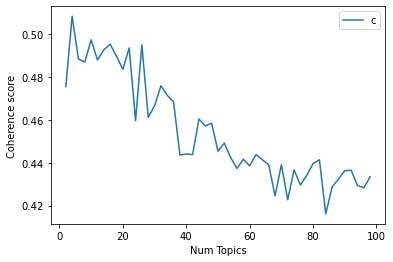

In [62]:
# Show graph
limit=100; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



In [63]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4754
Num Topics = 4  has Coherence Value of 0.5083
Num Topics = 6  has Coherence Value of 0.4883
Num Topics = 8  has Coherence Value of 0.487
Num Topics = 10  has Coherence Value of 0.4973
Num Topics = 12  has Coherence Value of 0.4879
Num Topics = 14  has Coherence Value of 0.4926
Num Topics = 16  has Coherence Value of 0.4953
Num Topics = 18  has Coherence Value of 0.4895
Num Topics = 20  has Coherence Value of 0.4836
Num Topics = 22  has Coherence Value of 0.4935
Num Topics = 24  has Coherence Value of 0.4596
Num Topics = 26  has Coherence Value of 0.495
Num Topics = 28  has Coherence Value of 0.4611
Num Topics = 30  has Coherence Value of 0.4665
Num Topics = 32  has Coherence Value of 0.4758
Num Topics = 34  has Coherence Value of 0.4714
Num Topics = 36  has Coherence Value of 0.4683
Num Topics = 38  has Coherence Value of 0.4436
Num Topics = 40  has Coherence Value of 0.444
Num Topics = 42  has Coherence Value of 0.4438
Num Topics = 44  has

In [70]:
best_model = model_list[1]
print(best_model)

LdaModel(num_terms=41698, num_topics=4, decay=0.5, chunksize=100)


In [71]:
#is our perplexity better than our manual model?
#-12.14, actually better 
print('\nBest Model Perplexity: ', best_model.log_perplexity(f_corpus))  # a measure of how good the model is. lower the better.


Best Model Perplexity:  -7.328159262306777


In [72]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, f_corpus, id2word)
vis

c:\users\eovit\miniconda3\envs\virt\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.036551  0.040677       1        1  39.385532
3      0.182514 -0.046742       2        1  31.370140
2     -0.114525 -0.122867       3        1  16.075464
0     -0.031439  0.128932       4        1  13.168859, topic_info=    Category          Freq        Term         Total  loglift  logprob
741  Default  22837.000000     patient  22837.000000  30.0000  30.0000
26   Default  20482.000000        cell  20482.000000  29.0000  29.0000
378  Default  31489.000000        case  31489.000000  28.0000  28.0000
646  Default  32603.000000     license  32603.000000  27.0000  27.0000
683  Default  25082.000000       model  25082.000000  26.0000  26.0000
..       ...           ...         ...           ...      ...      ...
567   Topic4   1834.967529       grant  17465.373047  -0.2259  -5.4761
675   Topic4   1794.452271     medrxiv  17466.414062  -0.2483  -5.4984
748   Topic4   1755.484009  perpetuity  16942.281250  -0.2398  -5.5203
187   Topic4   1683.966553    preprint  21936.779297  -0.5397  -5.5619
359   Topic4   1551.021851        base   9876.688477   0.1761  -5.6442

[361 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
7859      3  0.998238  abnormality
2389      4  0.998114     academic
320       1  0.080204    admission
320       3  0.919009    admission
321       1  0.113847        admit
...     ...       ...          ...
1365      1  0.997414      weather
977       1  0.449218         work
977       2  0.203354         work
977       3  0.015662         work
977       4  0.331631         work

[662 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [73]:
pprint(best_model.print_topics())

[(0,
  '0.013*"test" + 0.011*"sample" + 0.010*"use" + 0.009*"license" + '
  '0.007*"available" + 0.007*"make" + 0.006*"study" + 0.006*"author" + '
  '0.006*"positive" + 0.005*"covid"'),
 (1,
  '0.020*"case" + 0.017*"model" + 0.015*"number" + 0.012*"license" + '
  '0.010*"time" + 0.010*"rate" + 0.009*"population" + 0.009*"estimate" + '
  '0.008*"infection" + 0.008*"available"'),
 (2,
  '0.039*"patient" + 0.022*"license" + 0.017*"study" + 0.016*"author" + '
  '0.015*"display" + 0.015*"funder" + 0.014*"medrxiv" + 0.014*"grant" + '
  '0.014*"perpetuity" + 0.012*"preprint"'),
 (3,
  '0.018*"cell" + 0.013*"use" + 0.011*"protein" + 0.009*"sequence" + '
  '0.009*"virus" + 0.008*"review" + 0.008*"copyright" + 0.008*"preprint" + '
  '0.007*"gene" + 0.007*"holder"')]


# Assigning topics to each observation
The next step is to use the full list of papers in order to assign each paper entry (that includes the body of the paper).

This can also be done using the abstracts, as the abstract should determine some amount of information, where I = len(abstract)/len(full_paper).


In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=spall_data):
    # Init output
    covid_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        print(row)
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         print(row)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0: 
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     covid_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     covid_topics_df = pd.concat([covid_topics_df, contents], axis=1)
#     return(covid_topics_df)

# Bibliography

-SPACY

-GENSIM

-https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
